## My fake news prototype


Comprises of two data files 

1 real news.csv file 

1 fake news.csv file 

I can add more later on 

Idea is to build a model and attach it to a chrome extension and have it highlight possible fake news articles 

I have also decided to possibly add in data from reddit posts from r/TheOnion and r/nottheonion.

The data in the fake.csv and real_news.csv has been authenticated from the people over at Kaggle

Using data from nottheonion is hard to authenticate due to the volume of posts however I am hoping that the users and moderators of the subreddit have filtered out those that are obviously not true.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
import csv

csv.field_size_limit(sys.maxsize)

# API scrape 
from psaw import PushshiftAPI

# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


In [5]:
fake_news = pd.read_csv("/Users/rossheaney/Desktop/Workspace/FourthYear/FYP/FakeNewsPrototype/Data/fake.csv", engine='python')
real_news = pd.read_csv("/Users/rossheaney/Desktop/Workspace/FourthYear/FYP/FakeNewsPrototype/Data/real_news.csv", engine='python')

## Lets see the shape of our dataset 

In [6]:
print(fake_news.shape)
print(real_news.shape)

(18001, 699)
(15712, 11)


### Lets see the columns 

In [7]:
print(list(fake_news.columns))
print(list(real_news.columns))

['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'thread_title', 'spam_score', 'main_img_url', 'replies_count', 'participants_count', 'likes', 'comments', 'shares', 'type', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69',

In [8]:
# now let's obtain similar features for both datasets before we combine them
# Let's add our label to the dataset "real" for real news and "fake" for fake news

real_news2 = real_news[['title', 'content', 'publication']]
real_news2['label'] = 'real'
real_news2.head(15)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real
5,"Among Travelers and Commuters, the Homeless St...",Wilson Silva said he knew the homeless situati...,New York Times,real
6,Bus Bombing in Jerusalem Wounds 21 - The New Y...,JERUSALEM — A bomb exploded on a bus in Jer...,New York Times,real
7,Syria Cease-Fire Crumbles as Bombings Kill Doz...,"BEIRUT, Lebanon — For 38 straight days, the...",New York Times,real
8,Iceland’s Water Cure - The New York Times,"On a frigid February day in Reykjavik, I stood...",New York Times,real
9,"Get to Know the Historical Figures on the $5, ...",WASHINGTON — The Treasury Department announ...,New York Times,real


In [9]:
fake_news2 = fake_news[['title', 'text','site_url']]
fake_news2['label'] = 'fake'
fake_news2.head(15)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,text,site_url,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup.com,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup.com,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup.com,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup.com,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup.com,fake
5,Hillary Goes Absolutely Berserk On Protester A...,Print Hillary goes absolutely berserk! She exp...,100percentfedup.com,fake
6,BREAKING! NYPD Ready To Make Arrests In Weiner...,BREAKING! NYPD Ready To Make Arrests In Weiner...,100percentfedup.com,fake
7,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,BREAKING! NYPD Ready To Make Arrests In Weiner...,100percentfedup.com,fake
8,BREAKING: CLINTON CLEARED...Was This A Coordin...,\nLimbaugh said that the revelations in the Wi...,100percentfedup.com,fake
9,"EVIL HILLARY SUPPORTERS Yell ""F*ck Trump""…Burn...",Email \nThese people are sick and evil. They w...,100percentfedup.com,fake


In [10]:
# let's rename the features in our datasets to be the same
newlabels = ['title', 'content', 'publication', 'label']
real_news2.columns = newlabels
fake_news2.columns = newlabels

# let's concatenate the dataframes
frames = [fake_news2, real_news2]
news_dataset = pd.concat(frames)
news_dataset


,title,content,publication,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup.com,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup.com,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup.com,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup.com,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup.com,fake
5,Hillary Goes Absolutely Berserk On Protester A...,Print Hillary goes absolutely berserk! She exp...,100percentfedup.com,fake
6,BREAKING! NYPD Ready To Make Arrests In Weiner...,BREAKING! NYPD Ready To Make Arrests In Weiner...,100percentfedup.com,fake
7,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,BREAKING! NYPD Ready To Make Arrests In Weiner...,100percentfedup.com,fake
8,BREAKING: CLINTON CLEARED...Was This A Coordin...,\nLimbaugh said that the revelations in the Wi...,100percentfedup.com,fake
9,"EVIL HILLARY SUPPORTERS Yell ""F*ck Trump""…Burn...",Email \nThese people are sick and evil. They w...,100percentfedup.com,fake


## Define the api scraper

In [11]:
def scrape_data(subreddit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=15000))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

## Scrape r/nottheonion 

In [12]:
# Call function and create DataFrame
df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# Save data to csv
df_not_onion.to_csv('./data/not_onion.csv')

# Shape of DataFrame
print(f'df_not_onion shape: {df_not_onion.shape}')

# Show head
df_not_onion.head()

nottheonion subscribers: 16275182
df_not_onion shape: (15000, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,TheBatfanTriumphant,joblo.com,0,1,nottheonion,1579882159,Danny McBride is Kanye West's choice to play t...
1,mcready67,marketwatch.com,1,1,nottheonion,1579882156,New Orleans Saints fight to shield Catholic Ch...
2,cowcowcow314,foxnews.com,0,1,nottheonion,1579881926,You’re full of shit.
3,Snakeb1te,theguardian.com,0,1,nottheonion,1579881849,The Wolf of Wall Street's Jordan Belfort sues ...
4,chevymonza,variety.com,2,1,nottheonion,1579881618,"Real-Life ‘Wolf of Wall Street’, Jordan Belfor..."


## Scrape r/theonion

In [13]:
# Call function and create DataFrame
df_onion = pd.DataFrame(scrape_data('theonion'))

# Save data to csv
df_onion.to_csv('./data/the_onion.csv')

# Shape of DataFrame
print(f'df_onion shape: {df_onion.shape}')

# Show head
df_onion.head()

theonion subscribers: 136492
df_onion shape: (15000, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,Jokersi_89,politics.theonion.com,11,1,TheOnion,1579850473,Trump Lifts Obama-Era Protections Trapping Gan...
1,aresef,ogn.theonion.com,1,1,TheOnion,1579813061,‘Kingdom Hearts III’ DLC Developers Panicking ...
2,dwaxe,news.clickhole.com,8,1,TheOnion,1579808486,Fascinating Trend: More And More Women Are Fre...
3,Sanlear,theonion.com,0,1,TheOnion,1579744739,Financial Experts Recommend Just Waiting Until...
4,DerpDuck2233,theonion.com,1,1,TheOnion,1579743627,PornHub Announces Contest To Allow One User Un...


In [14]:

# r/TheOnion DataFrame
df_onion = pd.read_csv('./data/the_onion.csv')

# r/nottheonion DataFrame
df_not_onion = pd.read_csv('./data/not_onion.csv')

In [15]:
# Show first 5 rows of df_onion
print("Shape:", df_onion.shape)
df_onion.head()

Shape: (15000, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,Jokersi_89,politics.theonion.com,11,1,TheOnion,1579850473,Trump Lifts Obama-Era Protections Trapping Gan...
1,1,aresef,ogn.theonion.com,1,1,TheOnion,1579813061,‘Kingdom Hearts III’ DLC Developers Panicking ...
2,2,dwaxe,news.clickhole.com,8,1,TheOnion,1579808486,Fascinating Trend: More And More Women Are Fre...
3,3,Sanlear,theonion.com,0,1,TheOnion,1579744739,Financial Experts Recommend Just Waiting Until...
4,4,DerpDuck2233,theonion.com,1,1,TheOnion,1579743627,PornHub Announces Contest To Allow One User Un...


In [16]:
# Show first 5 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion.head()

Shape: (15000, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,TheBatfanTriumphant,joblo.com,0,1,nottheonion,1579882159,Danny McBride is Kanye West's choice to play t...
1,1,mcready67,marketwatch.com,1,1,nottheonion,1579882156,New Orleans Saints fight to shield Catholic Ch...
2,2,cowcowcow314,foxnews.com,0,1,nottheonion,1579881926,You’re full of shit.
3,3,Snakeb1te,theguardian.com,0,1,nottheonion,1579881849,The Wolf of Wall Street's Jordan Belfort sues ...
4,4,chevymonza,variety.com,2,1,nottheonion,1579881618,"Real-Life ‘Wolf of Wall Street’, Jordan Belfor..."


In [17]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [18]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (14171, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,Jokersi_89,politics.theonion.com,11,1,TheOnion,1579850473,trump lifts obama era protections trapping gan...
1,1,aresef,ogn.theonion.com,1,1,TheOnion,1579813061,kingdom hearts iii dlc developers panicking a...
2,2,dwaxe,news.clickhole.com,8,1,TheOnion,1579808486,fascinating trend more and more women are free...
3,3,Sanlear,theonion.com,0,1,TheOnion,1579744739,financial experts recommend just waiting until...
4,4,DerpDuck2233,theonion.com,1,1,TheOnion,1579743627,pornhub announces contest to allow one user un...


In [19]:
# Call `clean_data(dataframe)` function
clean_data(df_not_onion)

New shape: (11863, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,TheBatfanTriumphant,joblo.com,0,1,nottheonion,1579882159,danny mcbride is kanye west s choice to play t...
1,1,mcready67,marketwatch.com,1,1,nottheonion,1579882156,new orleans saints fight to shield catholic ch...
2,2,cowcowcow314,foxnews.com,0,1,nottheonion,1579881926,you re full of shit
3,3,Snakeb1te,theguardian.com,0,1,nottheonion,1579881849,the wolf of wall street s jordan belfort sues ...
4,4,chevymonza,variety.com,2,1,nottheonion,1579881618,real life wolf of wall street jordan belfort c...


In [20]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
Unnamed: 0,0,0
author,0,0
domain,0,0
num_comments,0,0
score,0,0
subreddit,0,0
timestamp,0,0
title,0,0


In [21]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2015-12-24 09:46:02
TheOnion end date: 2020-01-24 07:21:13
nottheonion start date: 2019-11-03 17:55:18
nottheonion end date: 2020-01-24 16:09:19


In [22]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

## Most referenced authors in r/TheOnion

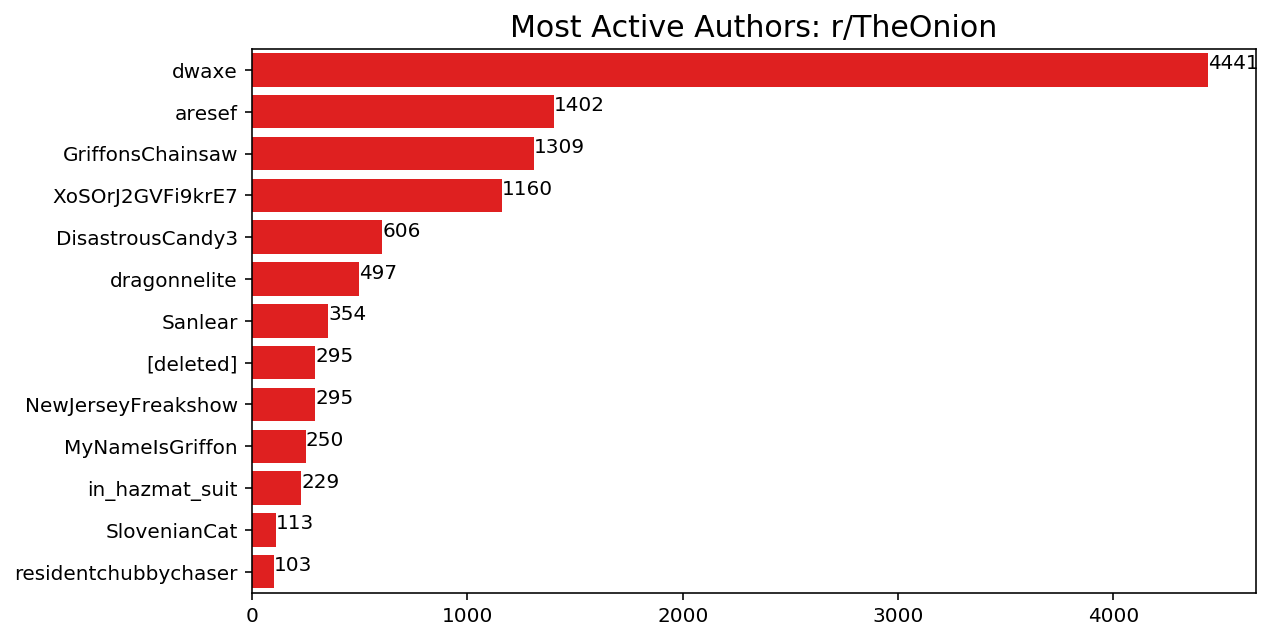

In [23]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r') 

## Most active authors in r/NotTheOnion

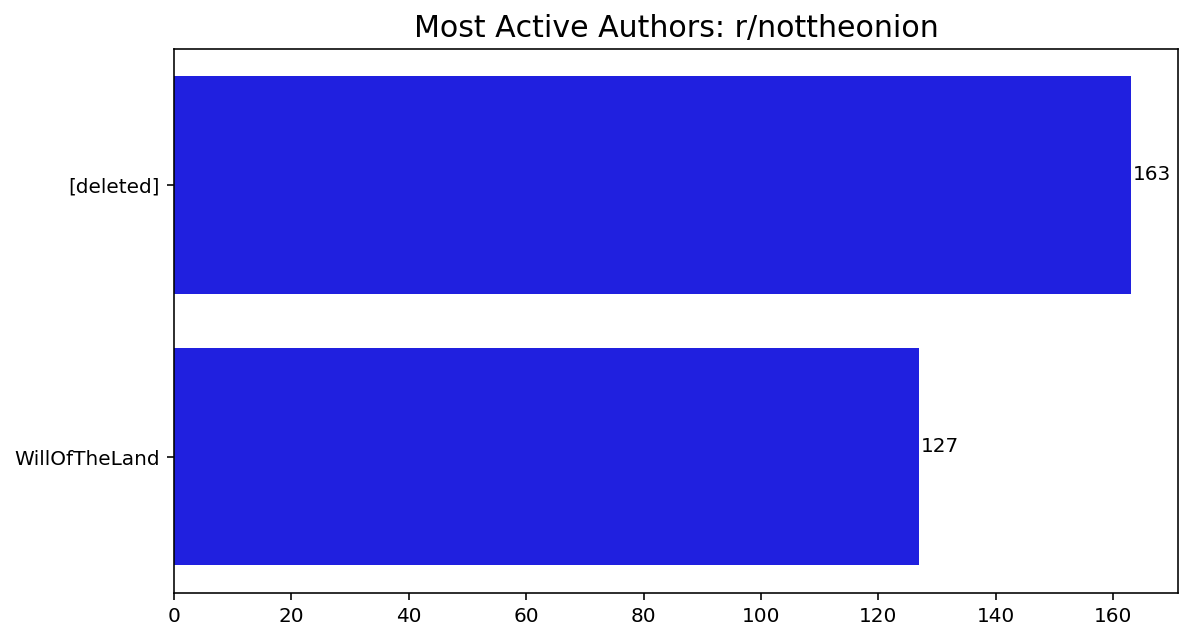

In [24]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b') 

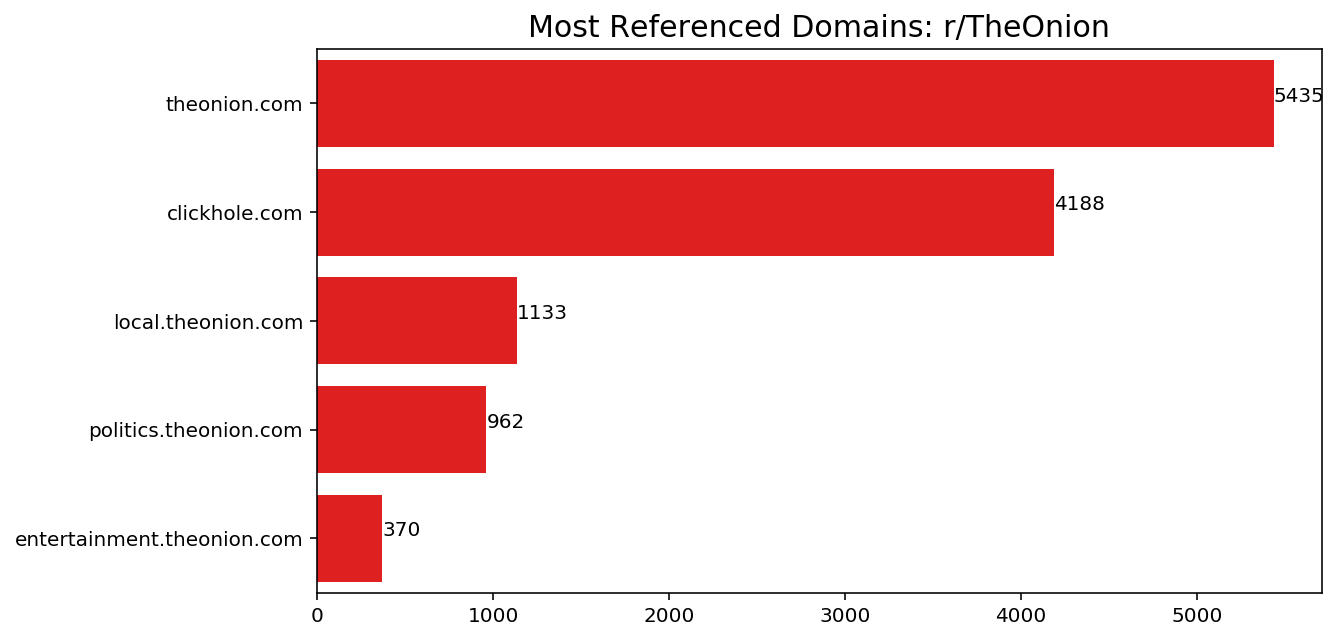

In [25]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r') 

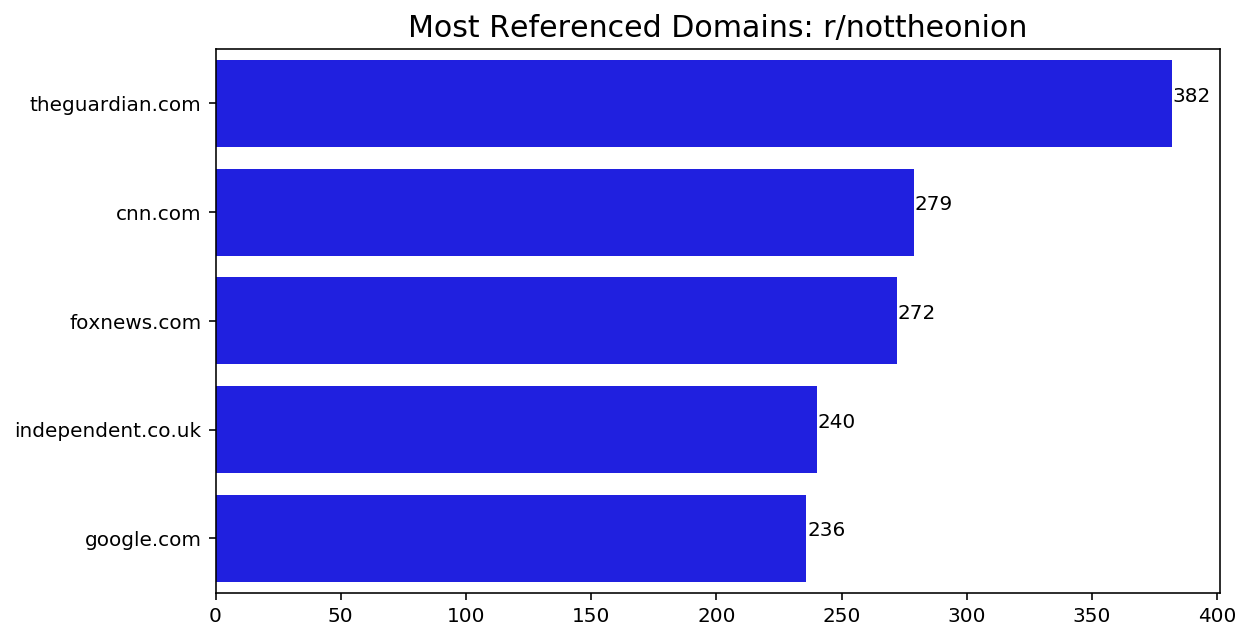

In [26]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b') 

## Lets do some natural language processing!

In [27]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,trump lifts obama era protections trapping gan...
1,TheOnion,kingdom hearts iii dlc developers panicking a...


In [28]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
26032,nottheonion,yoga teachers risking serious hip problems
26033,nottheonion,delta air lines restores same sex love scenes ...


In [29]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(26034, 2)


,subreddit,title
0,1,trump lifts obama era protections trapping gan...
1,1,kingdom hearts iii dlc developers panicking a...


In [30]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
26032,0,yoga teachers risking serious hip problems
26033,0,delta air lines restores same sex love scenes ...


In [31]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14171, 14288)


In [32]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11863, 14619)


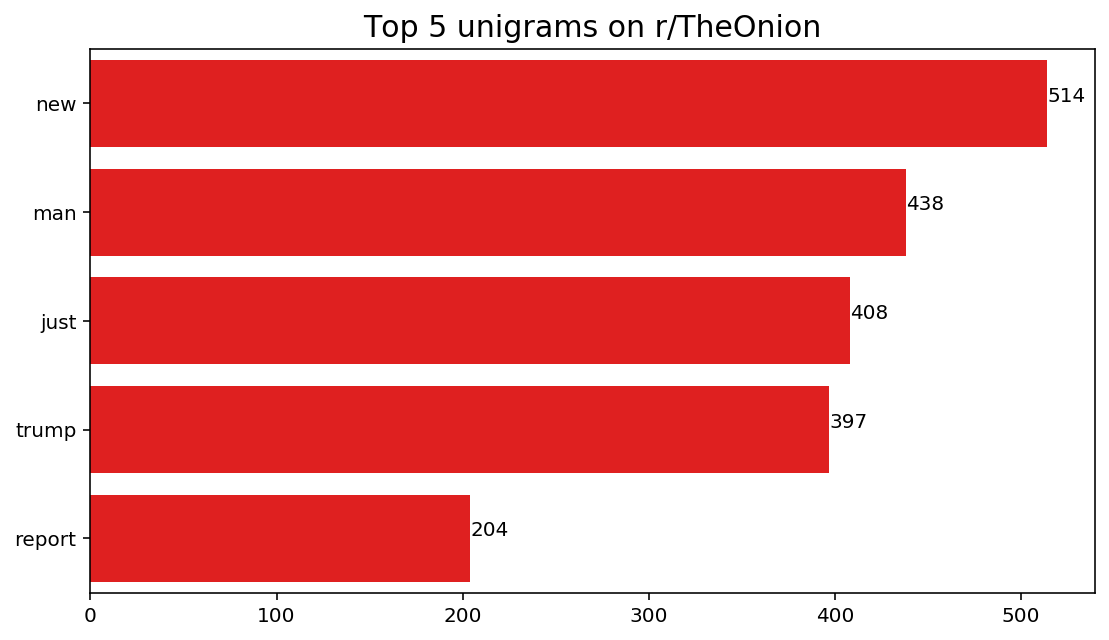

In [33]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r') 

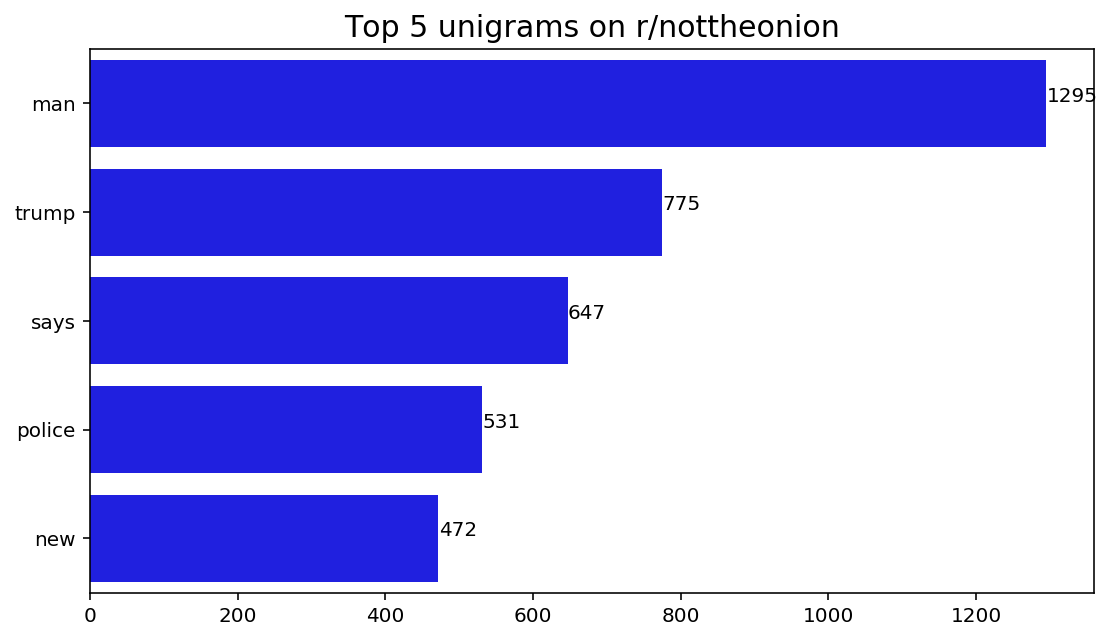

In [34]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b') 

In [35]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'new', 'trump'}

In [36]:
# Set variables to show TheOnion Titles
mask = df['subreddit'] == 1
df_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14171, 48481)


In [37]:
# Set variables to show NotTheOnion Titles
mask = df['subreddit'] == 0
df_not_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11863, 59167)


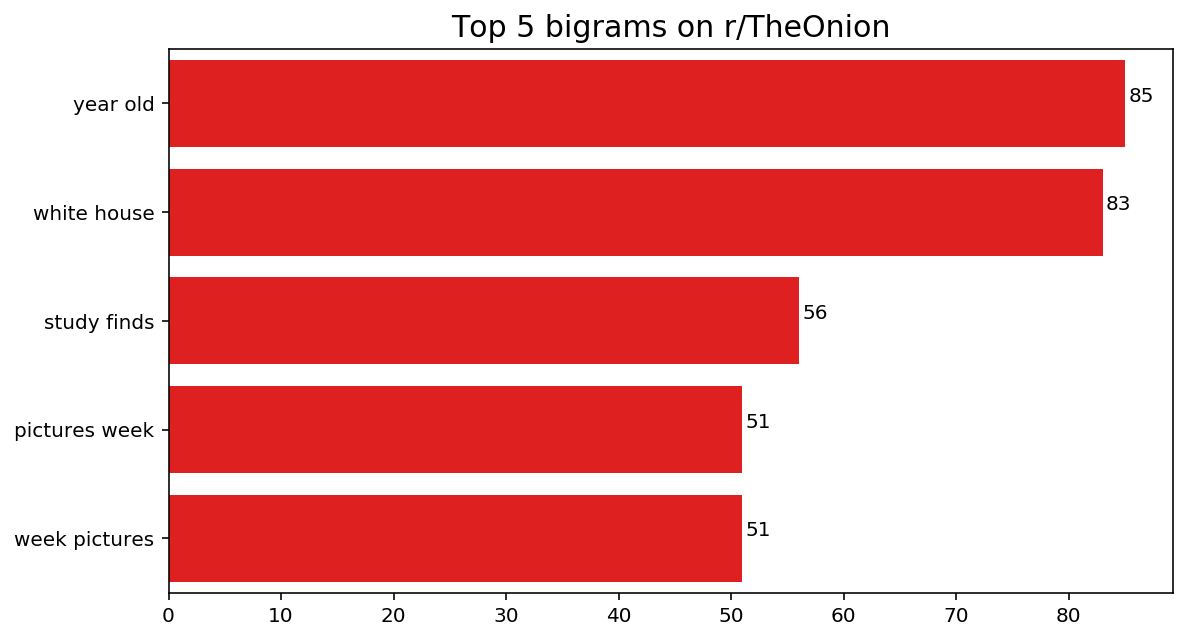

In [38]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 bigrams on r/TheOnion','r') 

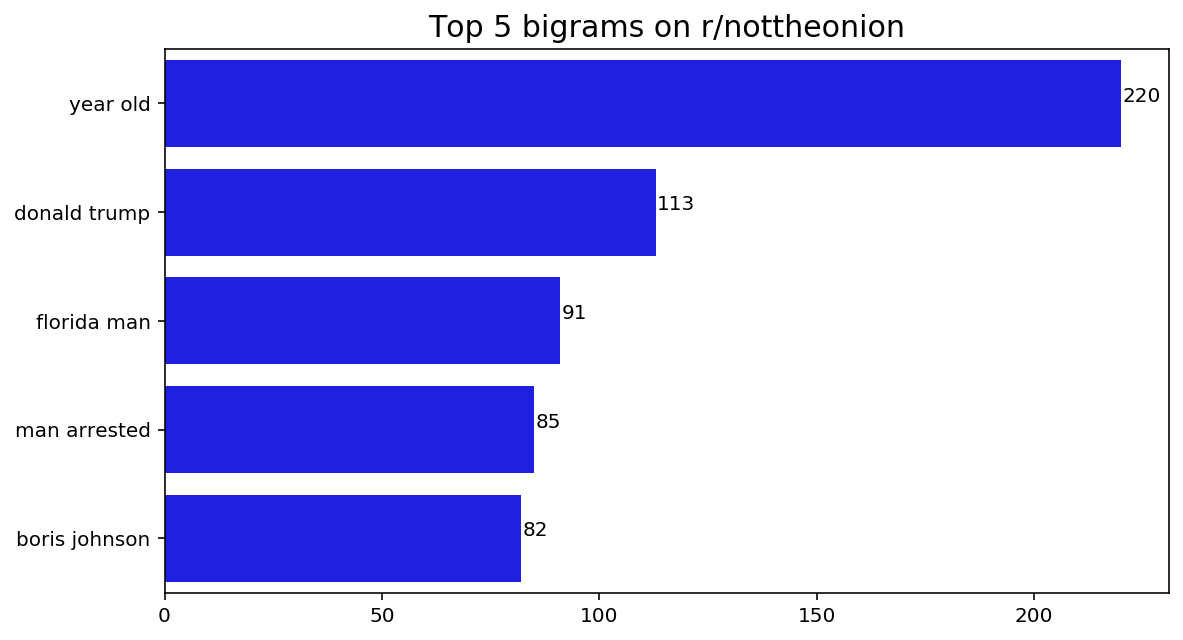

In [39]:
# Set up variables to contain top 5 most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 bigrams on r/nottheonion','b') 

In [40]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

{'year old'}

In [41]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

In [42]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.544327
0    0.455673
Name: subreddit, dtype: float64

In [43]:
X = df['title']
y = df['subreddit']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [45]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8371830985915493
Train score 0.9575928297055057
Test score 0.8505146719926256


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

In [46]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8296542893725992
Train score 0.910268886043534
Test score 0.8457520356429559


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 3,
 'tvect__ngram_range': (1, 3)}

In [47]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8720102432778489
Train score 0.9954417413572343
Test score 0.8815486249807958


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}

In [48]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8472215108834827
Train score 0.9142125480153649
Test score 0.8538946074665847


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

In [49]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8813949915501613


In [50]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2540,  426],
       [ 346, 3197]])

Text(0.5, 257.44, 'Predicted label')

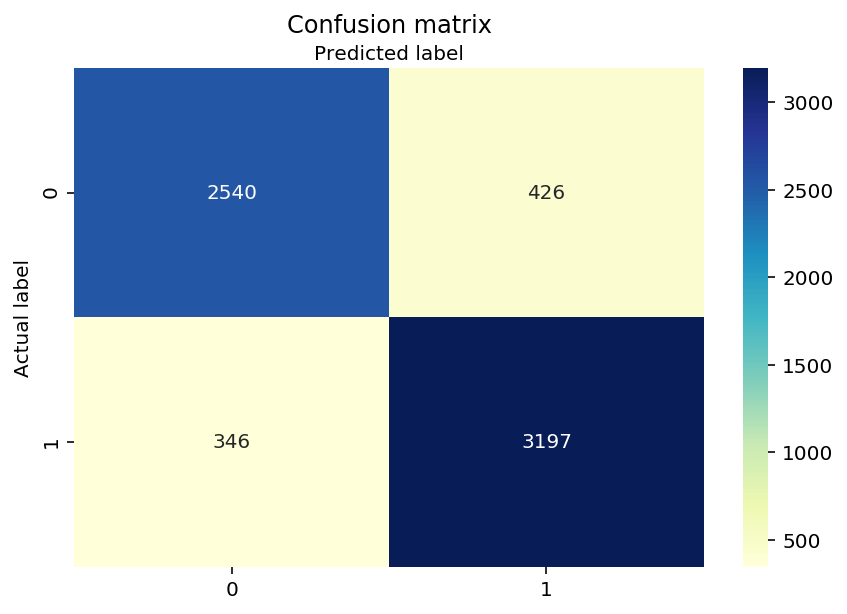

In [51]:

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [52]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [53]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 88.14 %
Precision: 88.24 %
Recall: 90.23 %
Specificity: 85.64 %
Misclassification Rate: 13.19 %


In [54]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')

In [55]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8429866338915348


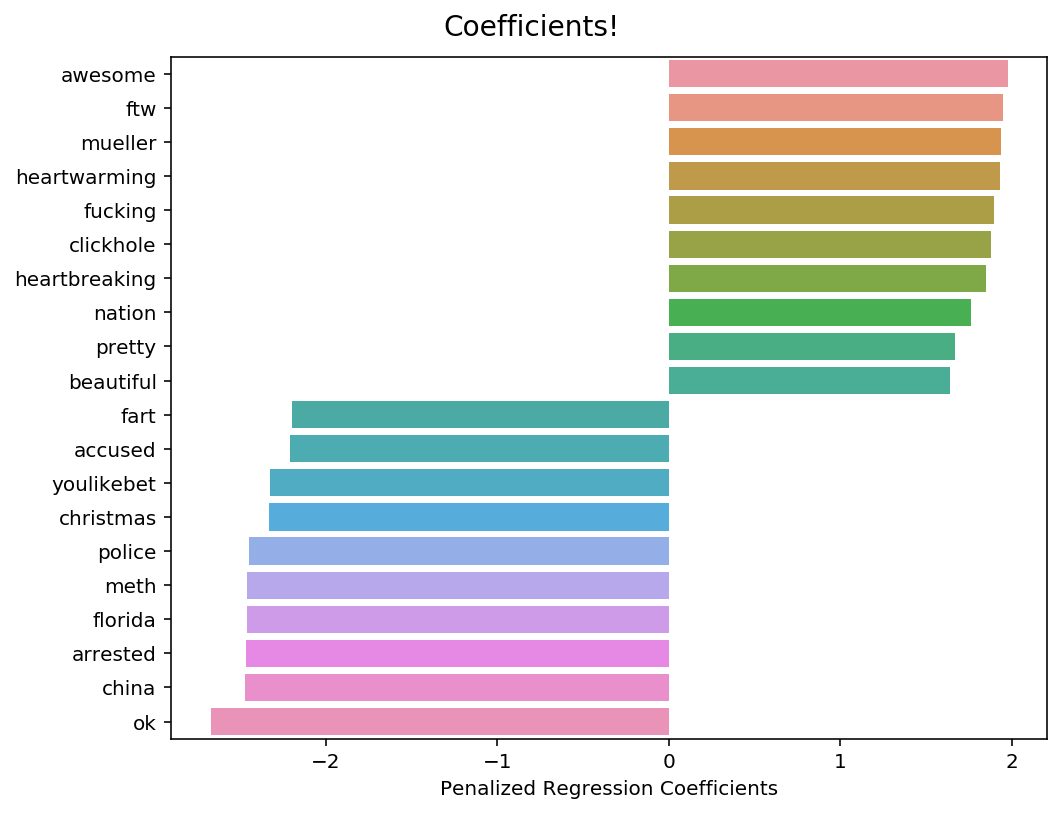

In [56]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [57]:
print("The word that contributes the most positively to being from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion is awesome followed by ftw and mueller .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is ok followed by china and arrested .


In [58]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
awesome,1.974,7.199417
ftw,1.948,7.014644
mueller,1.936,6.930972
heartwarming,1.928,6.875745
fucking,1.893,6.639257
clickhole,1.876,6.527343
heartbreaking,1.851,6.366183
nation,1.760,5.812437
pretty,1.666,5.290962
beautiful,1.639,5.150017


In [59]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of awesome increase by 1 in a title, that title is 7.2 times as likely to be classified as r/TheOnion.


In [60]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
ok,-2.673,14.483354
china,-2.472,11.846115
arrested,-2.464,11.751725
florida,-2.460,11.704812
meth,-2.458,11.681425
police,-2.448,11.565193
christmas,-2.334,10.319136
youlikebet,-2.326,10.236912
accused,-2.208,9.097503
fart,-2.200,9.025013


In [61]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of ok increase by 1 in a title, that title is 14.48 times as likely to be classified as r/nottheonion.
